In [1]:
import cbpro
import numpy as np
import datetime
import pandas as pd
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from scipy import stats
public_client = cbpro.PublicClient()

In [2]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,LeakyReLU
from keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import random
pd.set_option('precision', 4)

Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings("ignore")

## Extract data from API

In [4]:
def getData(label,start_time,end_time):
    '''pull out data from start date to end date'''
    #input
    #label -- string, type of currency, such as 'ETH-USD'
    #start_time, end_time -- ISO 8601 format date
    
    #output
    #numpy ndarray
    #pull out minute data
    data=public_client.get_product_historic_rates(label,start=start_time, end=end_time, granularity=300)
    return data

In [5]:
def getMinuteData(label, start_date, end_date):
    '''get all data of label from start_date to end_date'''
    sample = []
    date_list = pd.date_range(start=start_date, end=end_date)
    for head, tail in zip(date_list[:-1], date_list[1:]):
        tmp = getData(label,head.isoformat(),tail.isoformat())
        while len(tmp) == 1:
            time.sleep(0.8)
            tmp = getData(label,head.isoformat(),tail.isoformat())
        sample += tmp
        time.sleep(0.5)
    return sample

In [6]:
def save_data(data,tag):
    '''save the data in dictionary into separated csv file'''
    
    #transform to pandas dataframe format and add columne name
    result=pd.DataFrame(data,columns=['date','low','high','open','close','volume'])
    
    #transform unix time to datetime for better understand
    result['date']=pd.to_datetime(result['date'], unit='s')
    filename=tag+'_2017.csv'
    result.to_csv(filename)
    #return result    

In [7]:
# #extract from API and save into excel file
# #Extract 2017 data

# start_date, end_date = '08/15/2017', '08/15/2018'
# ticker = ticker=['BTC-USD','ETH-USD','LTC-USD']
# for tick in ticker:
#     data = getMinuteData(tick, start_date, end_date)
#     save_data(data, tick)

## Read Data from CSV file

In [7]:
def extract_merge(year):
    """extract data from csv file and merge them into 1 table"""
    tick = ['BTC', 'ETH', 'LTC']
    if year == '2018':
        ticker = ["Data/" + i + '-USD.csv' for i in tick]
    else:
        ticker = ["Data/" + i + '-USD_2017.csv' for i in tick]
    BTC_data = pd.read_csv(ticker[0],parse_dates=['date'])
    BTC_data=BTC_data.drop(BTC_data.columns[0],axis=1)
    ETH_data=pd.read_csv(ticker[1],parse_dates=['date'])
    ETH_data=ETH_data.drop(ETH_data.columns[0],axis=1)
    LTC_data=pd.read_csv(ticker[2],parse_dates=['date'])
    LTC_data=LTC_data.drop(LTC_data.columns[0],axis=1)
    
    #merge BTC & ETH data
    merge1=BTC_data.merge(ETH_data, how='inner', on='date', suffixes=('_BTC','_ETH'))
    #merge above table with LTC data
    merge2=pd.merge(merge1,LTC_data,how='inner', on='date')
    #change the colume name
    merge2=merge2.rename(columns={i:i+'_LTC' for i in list(LTC_data)[1:]})
    merge2 = merge2.drop_duplicates()
    
    return merge2

In [9]:
merge2 = extract_merge('2018')
merge2_2017 = extract_merge('2017')

## Start RNN model

### generate log return (here use percentage return)

In [10]:
# #change all price into log return
# def convert_log_return(data):
#     '''change price into percentage log return'''
    
#     #extract all volume data
#     volume_data = data.filter(like = "volume")
    
#     #find column that need to calculate percentage return
#     tag = ['BTC', 'LTC', 'ETH']
#     tick = ['open', 'close', 'high', 'low']
#     col_name_list = [j + "_" + i for i in tag for j in tick]
    
#     for col_name in col_name_list:
#         new_col_name = 'return_' + col_name
#         #calculate percentage change
#         tmp = data[col_name].pct_change()
        
#         #convert percentage return into log
#         #if return == 0, log return == 0
#         data[new_col_name] = tmp
    
#     #add volume back
#     return_matrix = pd.concat([data.filter(like='return'),volume_data], axis = 1)
    
#     return return_matrix

In [8]:
def calculate_log_return(df):
    df1 = np.asarray(df.iloc[1:].values.tolist())
    df2 = np.asarray(df.iloc[:-1].values.tolist())
    result = np.log(df1/df2)
    return result

In [9]:
def normalize(df):
    #normalization
    column_names = list(df)
    min_max_scaler = MinMaxScaler()
    return_matrix = pd.DataFrame(min_max_scaler.fit_transform(df), columns = column_names)
    return return_matrix

In [10]:
def convert_log_return(data, flag):
    """convert all price (except volumn) into log return"""
    """log return = log(x_t/x_{t-1})"""
    #initialize the dataframe
    return_matrix = pd.DataFrame()
    
    #find column that need to calculate percentage return
    tag = ['BTC', 'LTC', 'ETH']
    tick = ['open', 'close', 'high', 'low']
    col_name_list = [j + "_" + i for i in tag for j in tick]
    
    for col_name in col_name_list:
        df = data[col_name]
        return_matrix[col_name] = calculate_log_return(df)
    
    #add volume back
    volume_data = np.asarray(data.filter(like = "volume").iloc[1:].values.tolist())
    #get volume name for eacy cryptocurrency
    volume_list = ["volume_" + i for i in tag]
    for i in range(len(volume_list)):
        return_matrix[volume_list[i]] = volume_data[:,i]
        
    #if flag == true means need normalization
    if flag == True:
        return_matrix = normalize(return_matrix)
    
    #add date
    date_data = data['date'].tolist()
    return_matrix['date'] = pd.to_datetime(date_data[1:])
    
    return return_matrix

In [14]:
convert_log_return(merge2, True).head()

,open_BTC,close_BTC,high_BTC,low_BTC,open_LTC,close_LTC,high_LTC,low_LTC,open_ETH,close_ETH,high_ETH,low_ETH,volume_BTC,volume_LTC,volume_ETH,date
0,0.5704,0.5728,0.5675,0.5840,0.4238,0.4469,0.4161,0.4477,0.5738,0.5741,0.5705,0.5717,0.0054,0.0117,0.0076,2018-08-15 23:55:00
1,0.5626,0.5726,0.5606,0.5747,0.4201,0.4482,0.4174,0.4461,0.5607,0.5766,0.5650,0.5689,0.0107,0.0225,0.0217,2018-08-15 23:50:00
2,0.5698,0.5648,0.5605,0.5696,0.4250,0.4437,0.4152,0.4416,0.5740,0.5634,0.5602,0.5614,0.0210,0.0212,0.0210,2018-08-15 23:45:00
3,0.5691,0.5720,0.5653,0.5847,0.4216,0.4513,0.4189,0.4515,0.5701,0.5761,0.5778,0.5853,0.0106,0.0396,0.0392,2018-08-15 23:40:00
4,0.5656,0.5713,0.5653,0.5783,0.4189,0.4459,0.4134,0.4419,0.5606,0.5743,0.5785,0.5614,0.0225,0.0934,0.0348,2018-08-15 23:35:00


In [11]:
def create_dataset(data, time_step, tick1, tick2, target):
    '''convert time series data into X, y'''
    """given tag name(tick1, tick2) of two crpytocurrency"""
    """X = [low1, high1, open1, close1, volume1, low2, high2, open2, close2, volume2] for time (i, i + timestep)"""
    
    #use #timestep data from tick1, tick2 to predict next time stamp tick1' open price
    
    #create colume label
    input_label1 = [i + '_' + tick1 for i in ['low', 'high', 'open','close', 'volume']]
    input_label2 = [i + '_' + tick2 for i in ['low', 'high', 'open','close', 'volume']]
    target_label = 'close_' + target
    
    tmp_data1 = data[input_label1]
    tmp_data2 = data[input_label2]
    tmp_target = data[target_label]
    
    transformed_X = []
    transformed_y = []
    for i in range(time_step, data.shape[0]):
        tmp1 = tmp_data1[(i - time_step): i].values.tolist()
        tmp2 = tmp_data2[(i - time_step): i].values.tolist()
        tmp = []
        for j in range(len(tmp1)):
            tmp.append(tmp1[j] + tmp2[j])
            
        #tmp = [low1, high1, open1, close1, volume1, low2, high2, open2, close2, volume2]
        transformed_X.append(tmp)
        transformed_y.append(tmp_target.iloc[i])
    
    return np.asarray(transformed_X), np.asarray(transformed_y)

### train, test, validation split by week

In [12]:
def generate_week_list(start_date, end_date):
    '''generate the start and end day of each week'''
    '''week_list = {1: [start, end]}'''
    """In order to split train, test, validation in future step"""
    week_list = {}
    curr_week = start_date
    i = 1
    while curr_week < end_date:
        end_week = curr_week + datetime.timedelta(days = 7)
        week_list[i] = [curr_week, end_week]
        curr_week, i = end_week, i + 1
    
    return week_list

In [13]:
def extract_sample(index, week_list, date, X, y):
    '''given index of week we want to sample, extract corresponding sample'''
    
    sample_X, sample_y = [], []
    for i in index:
        start, end = week_list[i]
        tmp_index = [(date < end) & (date >= start)]
        try:
            sample_X = np.concatenate((sample_X, X[tmp_index]), axis = 0)
            sample_y = np.concatenate((sample_y, y[tmp_index]), axis = 0)
        except:
            sample_X = X[tmp_index]
            sample_y = y[tmp_index]
    
    return sample_X, sample_y

In [14]:
def train_test_val(X, y, date):
    '''split train, test, validation'''
    #-----------------------------------------#
    #--e.g. 52 weeks in total, 0.8, 0.1, 0.1--#
    #-----------------------------------------#
    
    start, end = date.iloc[0], date.iloc[-1]
    week_list = generate_week_list(start, end)
    index = list(week_list.keys())
    train_index, test_index = train_test_split(index, test_size = 0.2)
    test_index, val_index = train_test_split(test_index, test_size = 0.5)
    train_X, train_y = extract_sample(train_index, week_list, date, X, y)
    test_X, test_y = extract_sample(test_index, week_list, date, X, y)
    val_X, val_y = extract_sample(val_index, week_list, date, X, y)
    
    return train_X, train_y, test_X, test_y, val_X, val_y

### RNN main program

In [15]:
def step_decay(epoch):
    """learning rate scheduler"""
    """start from initial_rate, after epochs_drop step, drop"""
    initial_rate = 0.05
    drop = 0.1
    epochs_drop = 2.0
    
    lrate = initial_rate * math.pow(drop, math.floor((1 + epoch)/epochs_drop))
    
    return lrate
                                    

In [16]:
def train_RNN(train_X, train_y, test_X, test_y, val_X, val_y, drop_rate, hidden_unit):
    '''RNN'''
    
    #------------LSTM-------------------------

    n_step, n_feature = train_X.shape[1:]
    model = Sequential()

    # Embedding layer
    model.add(LSTM(hidden_unit, input_shape=(n_step, n_feature), activation='relu', return_sequences=False))
#     model.add(LSTM(hidden_unit, input_shape=(n_step, n_feature), return_sequences=False))
#     model.add(LeakyReLU(alpha=0.3))

    model.add(Dropout(drop_rate))
    model.add(Dense(8, activation='relu'))
#     model.add(Dense(16))
#     model.add(LeakyReLU(alpha=0.3))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    lrate = LearningRateScheduler(step_decay)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)
    history = model.fit(train_X, train_y, epochs=50, batch_size = 100, verbose=1, validation_data=(val_X, val_y), callbacks = [es])

    testPredict = model.predict(test_X)
    #score = model.evaluate(y_test, testPredict)
    
    return history, testPredict



In [17]:
def optimize(train_X, train_y, test_X, test_y, val_X, val_y):
    drop_rate = 0.4
    hidden_list = [16, 32, 64]
    best_score, best_unit = float("inf"), 100
    score_list = []
    for hidden_unit in hidden_list:
        #start RNN training
        history, testPredict = train_RNN(train_X, train_y, test_X, test_y, val_X, val_y, drop_rate, hidden_unit)
        score = history.history['val_loss'][0]
        score_list.append(score)
        if score < best_score:
            best_score = score
            best_unit = hidden_unit
            best_history = history
            best_pred = testPredict
        return score_list, best_score, best_unit, best_history, best_pred

In [18]:
def mainProgram(flag, tick1, tick2, target, drop_rate, hidden_unit):
    #read data
    merge2 = extract_merge('2018')
    merge2_2017 = extract_merge('2017')
    
    #convert log return
    return_matrix = convert_log_return(merge2, flag)
    
    #split X and y
    data = return_matrix
    time_step = 60 # about 5 hours
    #X is N x time_step x 10 matrix
    X, y = create_dataset(data, time_step, tick1, tick2, target)
    
    #train, test, validation split
    date = return_matrix['date'][time_step:]
    train_X, train_y, test_X, test_y, val_X, val_y = train_test_val(X, y, date)
    
    #start RNN training
    history, testPredict = train_RNN(train_X, train_y, test_X, test_y, val_X, val_y, drop_rate, hidden_unit)
    
    return history, testPredict, test_y

In [23]:
#use log return data (not normalize)
flag = False
tick1, tick2 = "BTC", "ETH"
target = "BTC"
drop_rate = 0.4
hidden_unit = 32
hist1, pred1, test1 = mainProgram(flag, tick1, tick2, target, drop_rate, hidden_unit)

Train on 82511 samples, validate on 12060 samples
Epoch 1/50
82511/82511 [==============================] - 38s 462us/step - loss: 195741.2889 - mean_absolute_error: 123.5815 - val_loss: 36991.1008 - val_mean_absolute_error: 92.3900
Epoch 2/50
82511/82511 [==============================] - 36s 434us/step - loss: 776542.5677 - mean_absolute_error: 160.5425 - val_loss: 896401.3437 - val_mean_absolute_error: 395.2872
Epoch 3/50
82511/82511 [==============================] - 37s 447us/step - loss: 1225076.9983 - mean_absolute_error: 263.5616 - val_loss: 93153.4494 - val_mean_absolute_error: 185.4734
Epoch 4/50
82511/82511 [==============================] - 36s 434us/step - loss: 278792.8478 - mean_absolute_error: 176.6433 - val_loss: 14474.6516 - val_mean_absolute_error: 55.3445
Epoch 5/50
82511/82511 [==============================] - 34s 416us/step - loss: 21741.5171 - mean_absolute_error: 52.3724 - val_loss: 676.5627 - val_mean_absolute_error: 9.4997
Epoch 6/50
82511/82511 [============

KeyboardInterrupt: 

In [20]:
#use log return data (normalize)
flag = True
tick1, tick2 = "BTC", "ETH"
target = "BTC"
drop_rate = 0.4
hidden_unit = 16
hist2, pred2, test2 = mainProgram(flag, tick1, tick2, target, drop_rate, hidden_unit)

Train on 82457 samples, validate on 12094 samples
Epoch 1/50
82457/82457 [==============================] - 33s 403us/step - loss: 0.0055 - mean_absolute_error: 0.0360 - val_loss: 0.0093 - val_mean_absolute_error: 0.0964
Epoch 2/50
82457/82457 [==============================] - 32s 388us/step - loss: 8.4762e-05 - mean_absolute_error: 0.0037 - val_loss: 0.0094 - val_mean_absolute_error: 0.0965
Epoch 3/50
82457/82457 [==============================] - 35s 419us/step - loss: 8.3161e-05 - mean_absolute_error: 0.0035 - val_loss: 0.0093 - val_mean_absolute_error: 0.0961
Epoch 4/50
82457/82457 [==============================] - 36s 432us/step - loss: 8.3019e-05 - mean_absolute_error: 0.0035 - val_loss: 0.0094 - val_mean_absolute_error: 0.0964
Epoch 5/50
82457/82457 [==============================] - 34s 412us/step - loss: 8.3420e-05 - mean_absolute_error: 0.0036 - val_loss: 0.0085 - val_mean_absolute_error: 0.0917
Epoch 6/50
82457/82457 [==============================] - 35s 420us/step - loss

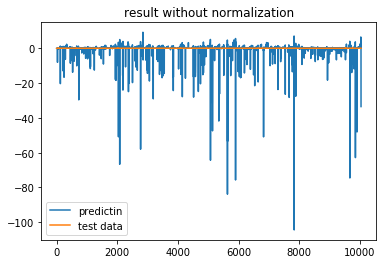

In [21]:
plt.plot(pred1, label = "predictin")
plt.plot(test1, label = "test data")
plt.legend()
plt.title("result without normalization")
plt.show()

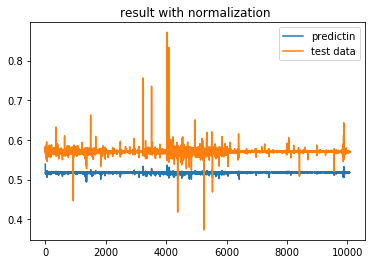

In [22]:
plt.plot(pred2, label = "predictin")
plt.plot(test2, label = "test data")
plt.legend()
plt.title("result with normalization ")
plt.show()

In [57]:
#merge2 is the extract & merge data
#return matrix stores all log return data

return_matrix = convert_log_return(merge2, True)


In [58]:
data = return_matrix
time_step = 60 # about 5 hours
tick1, tick2 = 'BTC', 'LTC'
target = 'BTC'
#X is N x time_step x 10 matrix
X, y = create_dataset(data, time_step, tick1, tick2, target)

In [59]:
date = return_matrix['date'][time_step:]
train_X, train_y, test_X, test_y, val_X, val_y = train_test_val(X, y, date)

In [27]:
train_X.shape

(82583, 60, 10)

In [28]:
test_X.shape

(10005, 60, 10)

In [60]:
history, testPredict = train_RNN(train_X, train_y, test_X, test_y, val_X, val_y, 0.4, 16)

Train on 82491 samples, validate on 12062 samples
Epoch 1/50
82491/82491 [==============================] - 34s 415us/step - loss: 0.0014 - mean_absolute_error: 0.0077 - val_loss: 4.8461e-05 - val_mean_absolute_error: 0.0034
Epoch 2/50
82491/82491 [==============================] - 33s 401us/step - loss: 8.9440e-05 - mean_absolute_error: 0.0033 - val_loss: 4.2841e-05 - val_mean_absolute_error: 0.0023
Epoch 3/50
82491/82491 [==============================] - 32s 393us/step - loss: 8.9697e-05 - mean_absolute_error: 0.0034 - val_loss: 4.2834e-05 - val_mean_absolute_error: 0.0024
Epoch 4/50
82491/82491 [==============================] - 32s 392us/step - loss: 8.9109e-05 - mean_absolute_error: 0.0032 - val_loss: 4.3178e-05 - val_mean_absolute_error: 0.0025
Epoch 5/50
82491/82491 [==============================] - 32s 389us/step - loss: 8.9181e-05 - mean_absolute_error: 0.0033 - val_loss: 4.2842e-05 - val_mean_absolute_error: 0.0023
Epoch 6/50
82491/82491 [==============================] - 3

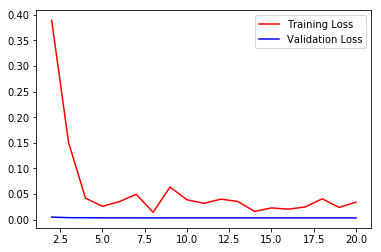

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(range(2, len(loss) + 1), loss[1:], 'r-', label='Training Loss')
plt.plot(range(2, len(loss) + 1), val_loss[1:], 'b-', label='Validation Loss')
plt.legend()
plt.show()

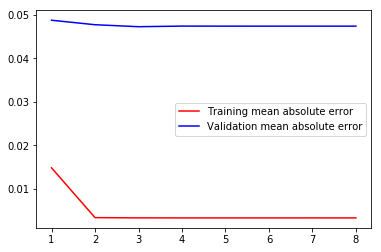

In [225]:
val_mae = history.history['val_mean_absolute_error']
mae= history.history['mean_absolute_error']
plt.plot(range(1, len(loss) + 1), mae, 'r-', label='Training mean absolute error')
plt.plot(range(1, len(loss) + 1), val_mae, 'b-', label='Validation mean absolute error')
plt.legend()
plt.show()

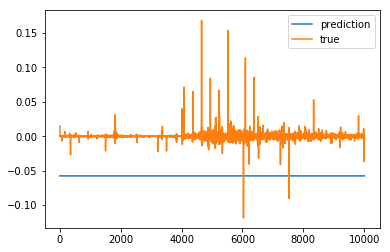

In [56]:
plt.plot(testPredict)
plt.plot(test_y)
plt.legend(['prediction','true'])

## Baseline: ARIMA

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA 

In [54]:
result = adfuller(test_y)

In [55]:
print("The p-value is: ", result[1])

The p-value is:  0.0


In [56]:
#find the order of ARIMA
min_p = min_q = float('inf')
min_bic = float('inf')
for p in range(1,8):
    for q in range(1,8):
        try:
            tmp_bic=ARIMA(test_y, (p, 0, q)).fit().bic
            if tmp_bic<min_bic:
                min_p,min_q=p,q
                min_bic=tmp_bic
        except:
            continue

In [34]:
model = ARIMA(test_y, (4, 0, 4)).fit()

In [35]:
pred_y = model.predict()

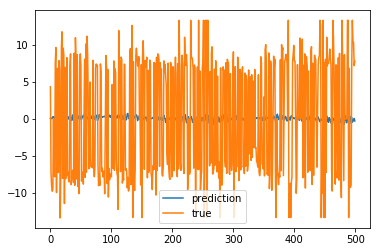

In [40]:
plt.plot(pred_y[:500])
plt.plot(test_y[:500])
plt.legend(['prediction','true'])

In [37]:
#model = ARIMA(train_data, (1, 0, 1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                10078
Model:                     ARMA(4, 4)   Log Likelihood              -35083.272
Method:                       css-mle   S.D. of innovations              7.864
Date:                Wed, 04 Sep 2019   AIC                          70186.545
Time:                        19:36:51   BIC                          70258.726
Sample:                             0   HQIC                         70210.968
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0756      0.069      1.096      0.273      -0.060       0.211
ar.L1.y        0.5863      0.123      4.785      0.000       0.346       0.826
ar.L2.y       -0.0440      0.129     -0.341      0.733      -0.297       0.209
ar.L3.y       -0.4287      0.133     -3.230      0.001      -0.689      -0.169
ar.L4.y        0.8143      0.102      7.949      0.000       0.614       1.015
ma.L1.y       -0.5882      0.127     -4.628      0.000      -0.837      -0.339
ma.L2.y        0.0378      0.133      0.284      0.776      -0.223       0.299
ma.L3.y        0.4174      0.138      3.028      0.002       0.147       0.687
ma.L4.y       -0.8034      0.106     -7.595      0.000      -1.011      -0.596
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0873           -0.0000j            1.0873           -0.5000
AR.2            0.2929           -1.0064j            1.0481           -0.2049
AR.3            0.2929           +1.0064j            1.0481            0.2049
AR.4            1.0281           -0.0000j            1.0281           -0.0000
MA.1           -1.0923           -0.0000j            1.0923           -0.5000
MA.2            0.2935           -1.0128j            1.0545           -0.2051
MA.3            0.2935           +1.0128j            1.0545            0.2051
MA.4            1.0248           -0.0000j            1.0248           -0.0000
-----------------------------------------------------------------------------
"""